In [1]:
from Bio import SeqIO
from Bio.AlignIO import MultipleSeqAlignment
from random import choice
from collections import Counter
from time import time

In [2]:
sequences = [s for s in SeqIO.parse('20150910_PB2s_2010-2015.fasta', 'fasta')]

def mc_length_sequences(sequences):
    """
    Filters a list of SeqRecords such that:
    - What's left is of the most common length only.
    """
    # Custom only for this notebook.
    # Pick out sequences that are of the most common length.
    counts = Counter([len(s) for s in sequences])
    mc_length = counts.most_common(1)[0][0]
    
    filtered_sequences = list()
    for s in sequences:
        if len(s.seq) == mc_length:
            filtered_sequences.append(s)
    return filtered_sequences

sequences = mc_length_sequences(sequences)

In [3]:
len(sequences)

4021

In [4]:
start = time()
polymorphisms = dict()
alignment = MultipleSeqAlignment(sequences)
for col in range(alignment.get_alignment_length()):
    polmorphs = set(alignment[:,col])
    if len(polmorphs) > 1:
        polymorphisms[col] = polmorphs
end = time()
print('Time: {0} seconds.'.format(end - start))

Time: 5.100972890853882 seconds.


In [5]:
total_positions = len(polymorphisms)
total_positions

754

In [6]:
def number_of_polymorphisms(polymorphisms):
    total_polymorphisms = 0
    for pos, polymorphs in polymorphisms.items():
        total_polymorphisms += len(polymorphs)

    return total_polymorphisms

total_polymorphisms = number_of_polymorphisms(polymorphisms)
total_polymorphisms

3365

In [7]:
# Implement algorithm for sampling.

subsampled = set()
start = time()

num_positions = []
num_polymorphisms = []

while len(polymorphisms.keys()) > 0:
    try:        
        # Step 1: Randomly choose a position with a polymorphism
        pos = choice(list(polymorphisms.keys()))

        # Step 2: Randomly choose one polymorphism.
        letter = choice(list(polymorphisms[pos]))

        # Step 3: Filter sequences such that we are left with sequences that have that letter at that position.
        filtered = MultipleSeqAlignment([s for s in alignment if s[pos] == letter])

        # Step 4: Randomly choose one of those sequences.
        seqrecord = choice(filtered)

        # Step 5: Add the chosen sequence to a subsampled set
        subsampled.add(seqrecord)

        # Step 6: Iterate over each of the positions in the polymorphisms, and if the sequence has a polymorphism, remove it
        # from consideration in the polymorphisms list.
        for pos in polymorphisms.keys():
            if seqrecord.seq[pos] in polymorphisms[pos]:
                polymorphisms[pos].remove(seqrecord.seq[pos])
                # print(pos, seqrecord.seq[pos])

        # Step 7: Refresh the dictionary such that no positions are left that have 0 polymorphisms to consider.
        polymorphisms = {k:v for k, v in polymorphisms.items() if len(v) > 0}
        
        num_positions.append(len(polymorphisms.keys()))
        num_polymorphisms.append(number_of_polymorphisms(polymorphisms))

    # Break if there's no more polymorphisms to choose from.
    except IndexError:
        break
    
end = time()

print('Time: {0} seconds'.format(end - start))

Time: 6.088326930999756 seconds


In [8]:
len(polymorphisms.keys()), len(subsampled)

(0, 973)

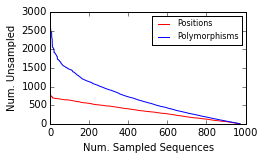

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(3.5,2))
plt.plot(num_positions, color='red', label='Positions')
plt.plot(num_polymorphisms, color='blue', label='Polymorphisms')
plt.legend(fontsize=8)
plt.xlabel('Num. Sampled Sequences', fontsize=10)
plt.ylabel('Num. Unsampled', fontsize=10)
plt.savefig('Polymorphisms Unsampled.pdf', bbox_inches='tight')

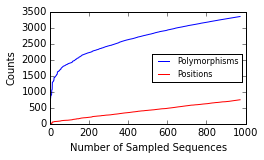

In [10]:
# Plot rarefaction curve
import numpy as np
num_polymorphs_arr = np.array(num_polymorphisms)
polymorph_coverage = total_polymorphisms - num_polymorphs_arr

num_positions_arr = np.array(num_positions)
position_coverage = total_positions - num_positions_arr

fig = plt.figure(figsize=(3.5,2))
plt.plot(polymorph_coverage, color='blue', label='Polymorphisms')
plt.plot(position_coverage, color='red', label='Positions')
plt.xlabel('Number of Sampled Sequences', fontsize=10)
plt.ylabel('Counts', fontsize=10)
plt.legend(fontsize=8, loc='right')

In [11]:
# How to evaluate the polymorphism coverage?
# We will use the metric "number of polymorphisms captured".

leftover_polymorphisms = 0
for pos, polymorphs in polymorphisms.items():
    leftover_polymorphisms += len(polymorphs)
leftover_polymorphisms

0

In [12]:
# Polymorphism coverage is as such:
1 - (leftover_polymorphisms / total_polymorphisms)

1.0

# Sampler Class Definition

Input: FASTA file of all sequences.
Output: FASTA file of a subset of sequences. Prints to screen the total polymorphism coverage. 